## Домашнее задание №4. Алгоритм построения дерева решений ##
<ol>
<li>В коде из методички реализуйте один или несколько критериев останова (количество листьев, глубина дерева и т.д.).
<li>Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.
<li>(*) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений.
</ol>

In [1]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np

In [2]:
# сгенерируем данные
np.random.seed(42)
classification_data, classification_labels = datasets.make_classification(n_samples=2000,  n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant = 0, 
                                                      n_clusters_per_class = 1, 
                                                      random_state = 5 )


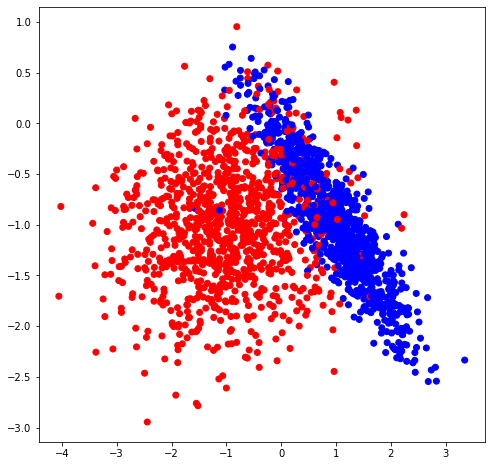

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction


In [5]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [6]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


In [7]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [8]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [9]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [10]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [11]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [12]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [13]:
#train_data,train_labels,

In [14]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.008008519684164161
--> True:
  Индекс 1
  Порог -0.20207113974292545
  --> True:
    Индекс 0
    Порог -0.17432971454374036
    --> True:
      Индекс 1
      Порог -0.3588273075800934
      --> True:
        Индекс 1
        Порог -0.9332809240314426
        --> True:
          Прогноз: 0
        --> False:
          Индекс 1
          Порог -0.9254064146497439
          --> True:
            Прогноз: 0
          --> False:
            Индекс 1
            Порог -0.8399414593628847
            --> True:
              Индекс 1
              Порог -0.8535903285432664
              --> True:
                Прогноз: 0
              --> False:
                Прогноз: 0
            --> False:
              Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.49143882655616145
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
    --> False:
      Индекс 1
      Порог -0.7744347554547725
      --> True:
        Прогноз: 0
      --> Fal

In [16]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [17]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [18]:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

95.07142857142857

In [19]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

90.33333333333333

Text(0.5, 1.0, 'Test accuracy=90.33')

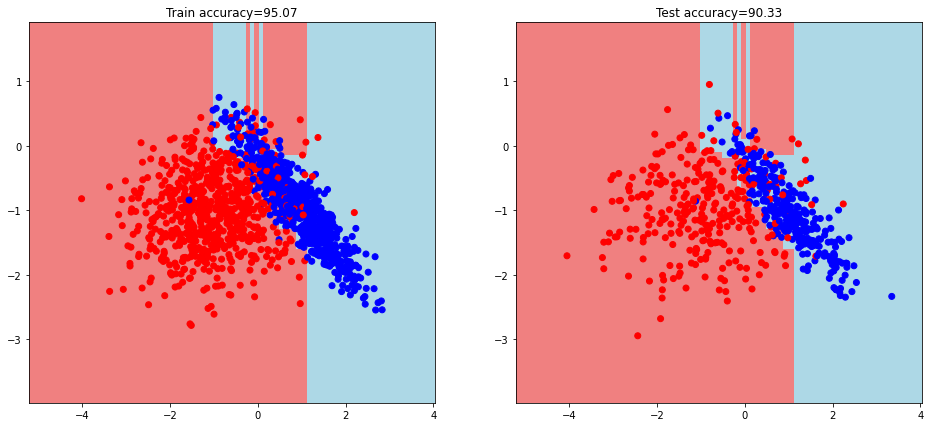

In [20]:
import warnings
warnings.filterwarnings('ignore')

# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

**Задание №1 В коде из методички реализуйте один или несколько критериев останова (количество листьев, глубина дерева и т.д.).**

**Глубина**

In [21]:
def build_tree(data, labels, max_depth=None):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    # Добавлены ветвления для параметра максимальной глубины
    if max_depth == None:
        true_branch = build_tree(true_data, true_labels)
        false_branch = build_tree(false_data, false_labels)
    elif max_depth >= 1:
        # Продолжаем рекурсию с передачей уменьшенного параметра максимальной глубины
        true_branch = build_tree(true_data, true_labels, max_depth - 1)
        false_branch = build_tree(false_data, false_labels, max_depth - 1)
    else:
        # Прекращаем рекурсию, если параметр максимальной глубины равен 0
        return Leaf(data, labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [22]:
d = 3

my_tree = build_tree(train_data, train_labels, d)

print_tree(my_tree)

Индекс 0
Порог 0.008008519684164161
--> True:
  Индекс 1
  Порог -0.20207113974292545
  --> True:
    Индекс 0
    Порог -0.17432971454374036
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0
    Порог -1.0360026640966344
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
--> False:
  Индекс 0
  Порог 0.4690398270276257
  --> True:
    Индекс 1
    Порог -0.9752910154943777
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Индекс 0
    Порог 1.0931531793787106
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1


In [23]:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

95.07142857142857

In [24]:
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

90.33333333333333

Text(0.5, 1.0, 'Test accuracy=90.33')

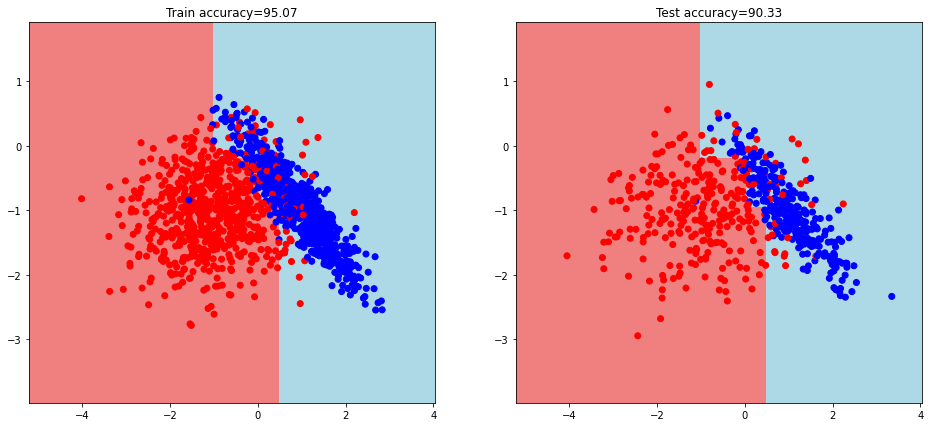

In [25]:
import warnings
warnings.filterwarnings('ignore')

# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

**Задание №2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.**

In [26]:
# Реализуем класс узла
class NodeReg:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index               # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t                       # значение порога
        self.true_branch = true_branch   # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch # поддерево, не удовлетворяющее условию в узле

# И класс терминального узла (листа)
class LeafReg:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = np.mean(labels) # self.predict()
        
#     def predict(self):
#         # подсчет количества объектов разных классов
#         classes = {}  # сформируем словарь "класс: количество объектов"
#         for label in self.labels:
#             if label not in classes:
#                 classes[label] = 0
#             classes[label] += 1
            
#         # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
#         prediction = max(classes, key=classes.get)
#         return prediction

# Разбиение датасета в узле

def split_reg(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

def quality_reg(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * np.std(left_labels) - (1 - p) * np.std(right_labels)

In [27]:
# Нахождение наилучшего разбиения

def find_best_split_reg(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_std = np.std(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_quality = quality_reg(true_labels, false_labels, root_std)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [28]:
def build_tree_reg(data, labels, max_depth=None):

    gain, t, index = find_best_split_reg(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return LeafReg(data, labels)

    true_data, false_data, true_labels, false_labels = split_reg(data, labels, index, t)

    # Рекурсивно строим два поддерева
    # Добавлены ветвления для параметра максимальной глубины
    if max_depth == None:
        true_branch = build_tree_reg(true_data, true_labels)
        false_branch = build_tree_reg(false_data, false_labels)
    elif max_depth >= 1:
        # Продолжаем рекурсию с передачей уменьшенного параметра максимальной глубины
        true_branch = build_tree_reg(true_data, true_labels, max_depth - 1)
        false_branch = build_tree_reg(false_data, false_labels, max_depth - 1)
    else:
        # Прекращаем рекурсию, если параметр максимальной глубины равен 0
        return LeafReg(data, labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

def classify_object_reg(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, LeafReg):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        # ИЗМЕНЕНО: исправлены функции в рекурсии
        return classify_object_reg(obj, node.true_branch)
    else:
        return classify_object_reg(obj, node.false_branch)

In [29]:
def predict_reg(data, tree):
    
    classes = []
    for obj in data:
        # исправлена функция
        prediction = classify_object_reg(obj, tree)
        classes.append(prediction)
    return classes

In [30]:
# Напечатаем ход нашего дерева
def print_tree_reg(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, LeafReg):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree_reg(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree_reg(node.false_branch, spacing + "  ")

In [31]:
my_tree_reg = build_tree_reg(train_data, train_labels, 10)

In [32]:
print_tree_reg(my_tree_reg)

Индекс 0 <= 0.008008519684164161
--> True:
  Индекс 1 <= -0.36433931656701435
  --> True:
    Индекс 1 <= -0.9332809240314426
    --> True:
      Прогноз: 0.0
    --> False:
      Индекс 0 <= -0.17432971454374036
      --> True:
        Индекс 1 <= -0.8399414593628847
        --> True:
          Индекс 0 <= -0.8430275415763726
          --> True:
            Индекс 0 <= -1.6553767190204784
            --> True:
              Прогноз: 0.0
            --> False:
              Индекс 0 <= -1.3469129801834143
              --> True:
                Прогноз: 0.2
              --> False:
                Индекс 1 <= -0.897741576326619
                --> True:
                  Прогноз: 0.2
                --> False:
                  Прогноз: 0.0
          --> False:
            Прогноз: 0.0
        --> False:
          Прогноз: 0.0
      --> False:
        Индекс 0 <= -0.08451599638576812
        --> True:
          Прогноз: 0.6
        --> False:
          Прогноз: 0.0
  --> False:
    Инд

In [33]:
train_answers_reg = predict_reg(train_data, my_tree_reg)
train_answers_reg

[0.875,
 1.0,
 0.6,
 0.0,
 0.2,
 0.0,
 0.875,
 1.0,
 1.0,
 0.875,
 0.8,
 0.0,
 1.0,
 0.0,
 0.5555555555555556,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.5,
 0.8,
 1.0,
 0.0,
 0.96,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.875,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.875,
 0.0,
 0.875,
 0.0,
 0.0,
 0.0,
 1.0,
 0.4,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.875,
 1.0,
 0.875,
 1.0,
 1.0,
 0.96,
 0.0,
 0.6,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.875,
 0.0,
 1.0,
 1.0,
 0.875,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.14285714285714285,
 0.0,
 0.875,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.6,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.8,
 1.0,
 0.0,
 1.0,
 0.0,
 0.875,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.875,
 0.875,
 0.7142857142857143,
 0.42857142857142855,
 0.875,
 0.0,
 0.0,
 1.0,
 0.0,
 0.875,
 1.0,
 0.0,
 0.875,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.4,
 0.0,
 1.0,
 0.0,
 0.0,
 1

In [34]:
# И получим ответы для тестовой выборки
answers = predict_reg(test_data, my_tree_reg)

In [35]:
train_accuracy = accuracy_metric(train_labels, train_answers_reg)
train_accuracy


76.42857142857142

In [36]:
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

70.33333333333334

In [37]:
import warnings
warnings.filterwarnings('ignore')

%time


plt.figure(figsize = (16, 7))

x = []
y1 = []
y2 = []

for depth in range(23):
    my_tree_reg = build_tree_reg(train_data, train_labels, depth)
    train_answers_reg = predict_reg(train_data, my_tree_reg)
    answers = predict_reg(test_data, my_tree_reg)
    train_accuracy = accuracy_metric(train_labels, train_answers_reg)
    test_accuracy = accuracy_metric(test_labels, answers)
    x.append(depth)
    y1.append(train_accuracy)
    y2.append(test_accuracy)

  


Wall time: 0 ns


<Figure size 1152x504 with 0 Axes>

Text(0, 0.5, 'accuracy [1..100]%')

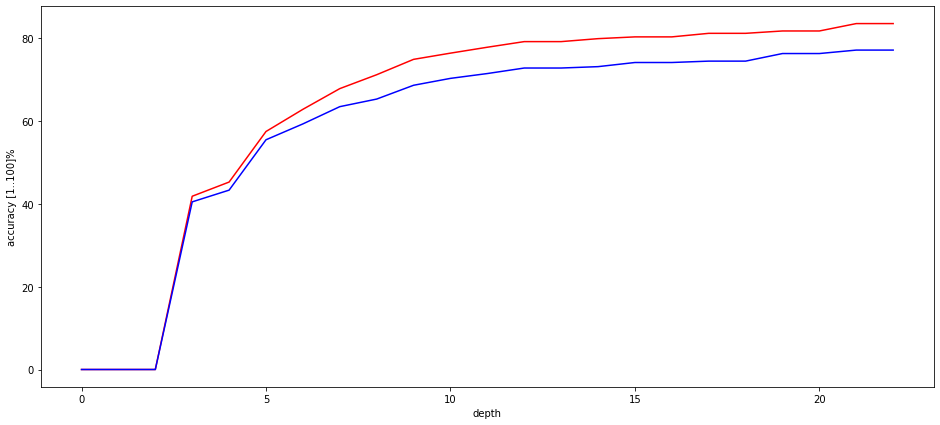

In [38]:
plt.figure(figsize = (16, 7))
plt.plot(x,y1, color='red')
plt.plot(x,y2, color ='blue')
plt.xlabel('depth')
plt.ylabel('accuracy [1..100]%')


In [39]:
for i in range(len(x)):
    print(x[i], y1[i], y2[i])
    

0 0.0 0.0
1 0.0 0.0
2 0.0 0.0
3 41.85714285714286 40.5
4 45.285714285714285 43.333333333333336
5 57.49999999999999 55.50000000000001
6 62.857142857142854 59.333333333333336
7 67.85714285714286 63.5
8 71.21428571428572 65.33333333333333
9 74.92857142857143 68.66666666666667
10 76.42857142857142 70.33333333333334
11 77.85714285714286 71.5
12 79.21428571428571 72.83333333333334
13 79.21428571428571 72.83333333333334
14 79.92857142857143 73.16666666666667
15 80.35714285714286 74.16666666666667
16 80.35714285714286 74.16666666666667
17 81.21428571428572 74.5
18 81.21428571428572 74.5
19 81.78571428571428 76.33333333333333
20 81.78571428571428 76.33333333333333
21 83.57142857142857 77.16666666666666
22 83.57142857142857 77.16666666666666
